In [56]:
import pandas as pd
train_df = pd.read_csv("output2.csv")
test_df  = pd.read_csv("test.csv")

In [82]:
train_df["datetime"] = pd.to_datetime(train_df["datetime"], utc=True)
test_df["datetime"]  = pd.to_datetime(test_df["datetime"], utc=True)

In [57]:
def create_lag_features(df):
    df = df.sort_values("datetime").copy()

    for lag in [1, 3, 6]:
        df[f"PM2_5_lag{lag}"] = df["PM2_5"].shift(lag)
        df[f"WS2M_lag{lag}"] = df["WS2M"].shift(lag)

    return df.dropna()


In [58]:
train_df = create_lag_features(train_df)
test_df  = create_lag_features(test_df)


In [59]:
train_df.head()

,Unnamed: 0,datetime,PM10,PM2_5,NITROGEN_DIOXIDE,SULPHUR_DIOXIDE,OZONE,CARBON_MONOXIDE,T2M,RH2M,WS2M,WD2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,PM2_5_lag1,WS2M_lag1,PM2_5_lag3,WS2M_lag3,PM2_5_lag6,WS2M_lag6
6,6,2022-10-01 06:00:00+00:00,88.0,55.4,19.6,39.5,158.0,492.0,31.54,57.36,2.41,318.2,0.01,755.10,64.7,2.00,100.8,1.28,127.6,0.39
7,7,2022-10-01 07:00:00+00:00,81.7,50.9,11.9,35.0,172.0,362.0,31.94,56.34,2.69,321.3,0.01,720.75,55.4,2.41,78.5,1.57,118.0,0.56
8,8,2022-10-01 08:00:00+00:00,77.5,47.6,9.4,28.8,176.0,311.0,32.31,54.07,2.90,322.1,0.02,635.65,50.9,2.69,64.7,2.00,111.5,1.21
9,9,2022-10-01 09:00:00+00:00,74.0,44.9,15.2,23.4,166.0,358.0,32.14,53.24,2.83,322.0,0.01,494.23,47.6,2.90,55.4,2.41,100.8,1.28
10,10,2022-10-01 10:00:00+00:00,73.3,44.2,30.0,23.9,141.0,470.0,31.41,57.01,2.30,322.6,0.01,307.30,44.9,2.83,50.9,2.69,78.5,1.57


In [60]:
feature_cols = [
    "WS2M", "RH2M", "T2M", "ALLSKY_SFC_SW_DWN",
    "PM2_5_lag1", "PM2_5_lag3", "PM2_5_lag6",
    "WS2M_lag1", "WS2M_lag3", "WS2M_lag6"
]

X_train = train_df[feature_cols]
y_train = train_df["PM2_5"]

X_test  = test_df[feature_cols]
y_test  = test_df["PM2_5"]


In [80]:
test_df["datetime"] = pd.to_datetime(test_df["datetime"], utc=True)


In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [62]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)


In [63]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly  = poly.transform(X_test_scaled)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
poly_pred = poly_reg.predict(X_test_poly)


In [64]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)


In [65]:
from sklearn.svm import SVR

svr = SVR(kernel="rbf")
svr.fit(X_train_scaled, y_train)
svr_pred = svr.predict(X_test_scaled)


In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }


In [ ]:
results = pd.DataFrame([
    {"Model": "Linear Regression", **evaluate(y_test, lr_pred)},
    {"Model": "Polynomial Regression", **evaluate(y_test, poly_pred)},
    {"Model": "KNN Regressor", **evaluate(y_test, knn_pred)},
    {"Model": "SVR", **evaluate(y_test, svr_pred)}
])

results = results.sort_values("RMSE")
best_model_name = results.iloc[0]["Model"]
results

,Model,MAE,RMSE,R2
2,KNN Regressor,15.153256,20.729765,0.849734
0,Linear Regression,20.857789,22.214886,0.827432
1,Polynomial Regression,22.907813,30.447017,0.675839
3,SVR,36.394902,50.324531,0.114414


In [83]:
test_df = test_df.iloc[-len(knn_pred):].copy()
test_df["PM2_5_pred"] = knn_pred

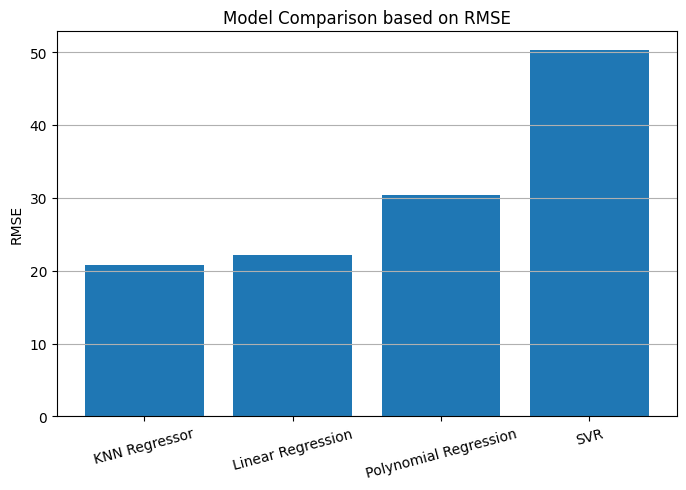

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results["Model"], results["RMSE"])
plt.ylabel("RMSE")
plt.title("Model Comparison based on RMSE")
plt.xticks(rotation=15)
plt.grid(axis="y")
plt.show()


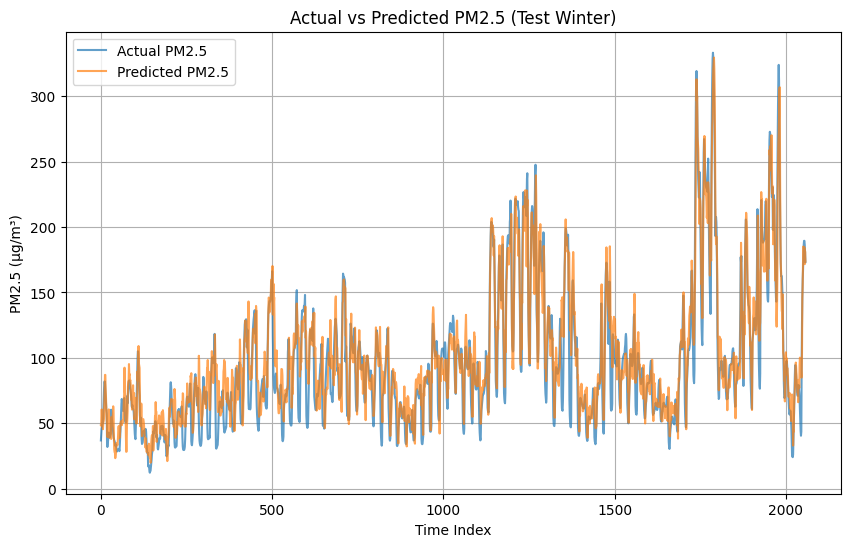

In [77]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual PM2.5", alpha=0.7)
plt.plot(knn_pred, label="Predicted PM2.5", alpha=0.7)
plt.title("Actual vs Predicted PM2.5 (Test Winter)")
plt.xlabel("Time Index")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()


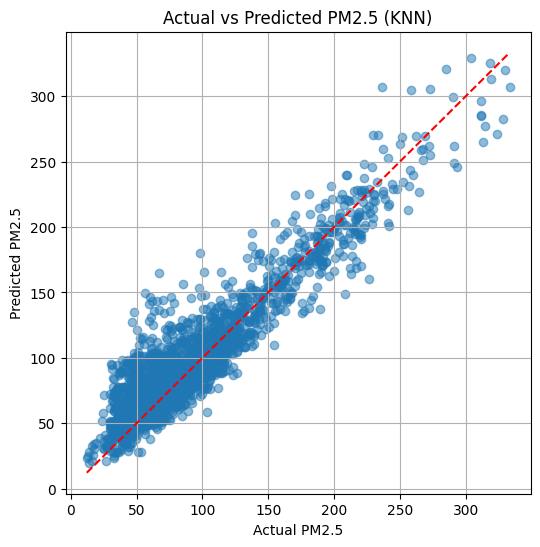

In [78]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, knn_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5 (KNN)")
plt.grid(True)
plt.show()


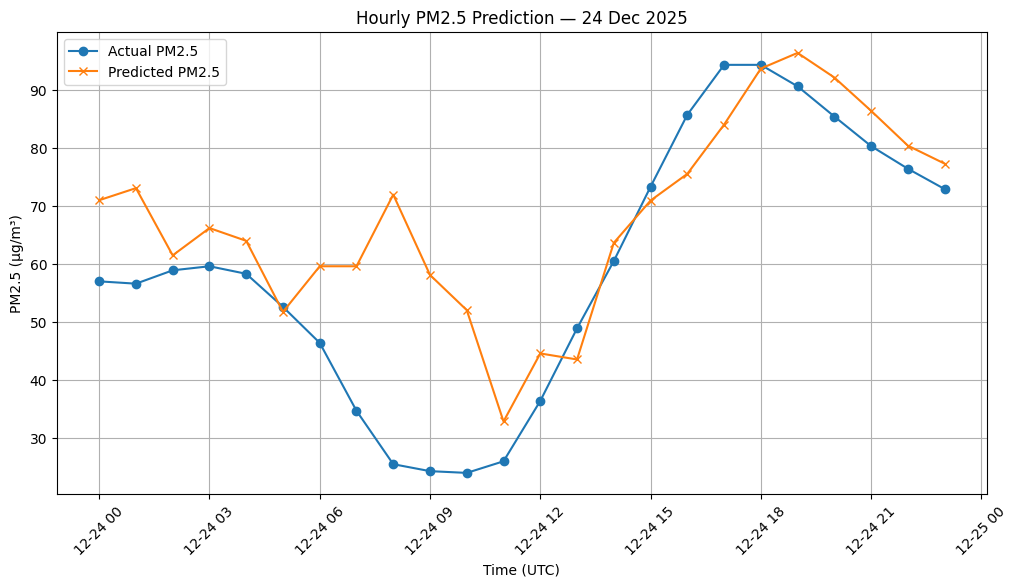

In [84]:
day_df = test_df[
    test_df["datetime"].dt.date == pd.to_datetime("2025-12-24").date()
]

plt.figure(figsize=(12,6))
plt.plot(day_df["datetime"], day_df["PM2_5"], label="Actual PM2.5", marker="o")
plt.plot(day_df["datetime"], day_df["PM2_5_pred"], label="Predicted PM2.5", marker="x")
plt.title("Hourly PM2.5 Prediction — 24 Dec 2025")
plt.xlabel("Time (UTC)")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [85]:
def calculate_pm25_aqi(pm25):
    if pm25 <= 30:
        return round((pm25 / 30) * 50)
    elif pm25 <= 60:
        return round(((pm25 - 31) / (60 - 31)) * (100 - 51) + 51)
    elif pm25 <= 90:
        return round(((pm25 - 61) / (90 - 61)) * (200 - 101) + 101)
    elif pm25 <= 120:
        return round(((pm25 - 91) / (120 - 91)) * (300 - 201) + 201)
    elif pm25 <= 250:
        return round(((pm25 - 121) / (250 - 121)) * (400 - 301) + 301)
    else:
        return round(((pm25 - 251) / (500 - 251)) * (500 - 401) + 401)


In [86]:
test_df["AQI_actual"] = test_df["PM2_5"].apply(calculate_pm25_aqi)
test_df["AQI_predicted"] = test_df["PM2_5_pred"].apply(calculate_pm25_aqi)

test_df["AQI_actual_cat"] = test_df["AQI_actual"].apply(aqi_category)
test_df["AQI_pred_cat"] = test_df["AQI_predicted"].apply(aqi_category)


In [87]:
day_df = test_df[
    test_df["datetime"].dt.date == pd.to_datetime("2025-12-24").date()
].copy()


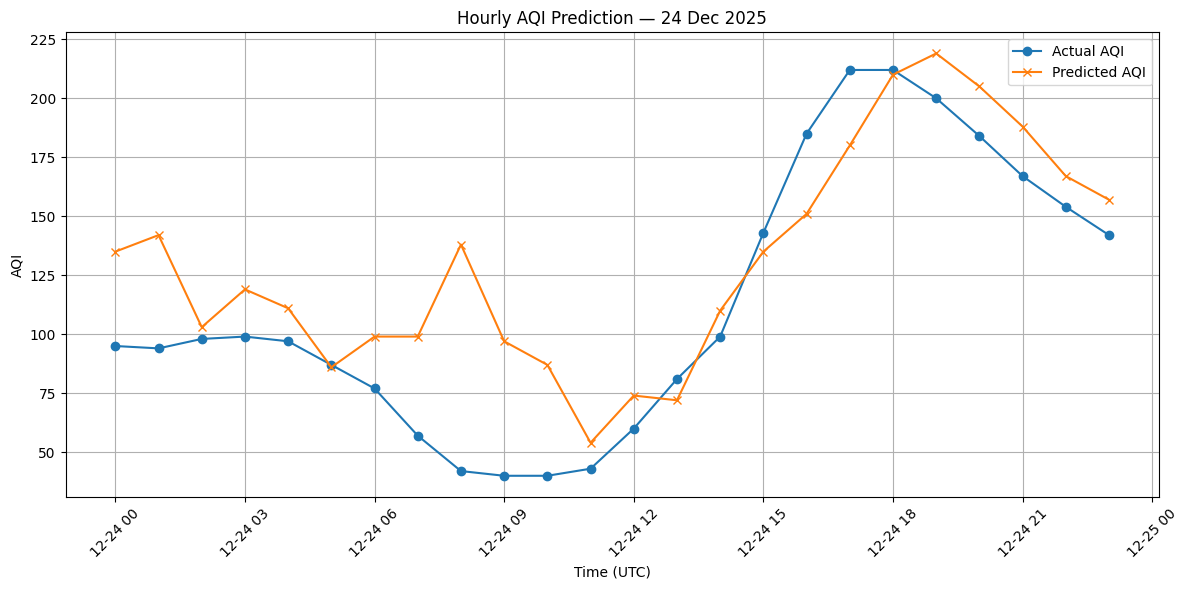

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(
    day_df["datetime"],
    day_df["AQI_actual"],
    label="Actual AQI",
    marker="o"
)

plt.plot(
    day_df["datetime"],
    day_df["AQI_predicted"],
    label="Predicted AQI",
    marker="x"
)

plt.xlabel("Time (UTC)")
plt.ylabel("AQI")
plt.title("Hourly AQI Prediction — 24 Dec 2025")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [89]:
def aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe (Hazardous)"


In [90]:
def predict_aqi_for_hour(df, target_datetime):
    target_datetime = pd.to_datetime(target_datetime)

    row = df[df["datetime"] == target_datetime]

    if row.empty:
        raise ValueError("This hour is not available after lag creation.")

    pm25_pred = row["PM2_5_pred"].values[0]
    aqi_pred = calculate_pm25_aqi(pm25_pred)
    category = aqi_category(aqi_pred)

    return pm25_pred, aqi_pred, category


In [92]:
target_hour = "2025-12-24 18:00:00+00:00"

pm25, aqi, cat = predict_aqi_for_hour(test_df, target_hour)

print("Datetime:", target_hour)
print("Predicted PM2.5:", round(pm25, 2), "µg/m³")
print("Predicted AQI:", aqi)
print("AQI Category:", cat)


Datetime: 2025-12-24 18:00:00+00:00
Predicted PM2.5: 93.66 µg/m³
Predicted AQI: 210
AQI Category: Poor


In [93]:
target_hours = [0, 4, 8, 12, 16, 20, 23]
target_date = pd.to_datetime("2025-12-24").date()


In [94]:
hourly_df = test_df[
    (test_df["datetime"].dt.date == target_date) &
    (test_df["datetime"].dt.hour.isin(target_hours))
].copy()


In [98]:
result_table = hourly_df[[
    "datetime",
    "PM2_5",
    "PM2_5_pred",
    "AQI_actual",
    "AQI_predicted",
    "AQI_actual_cat",
    "AQI_pred_cat"
]].sort_values("datetime")


In [99]:
result_table


,datetime,PM2_5,PM2_5_pred,AQI_actual,AQI_predicted,AQI_actual_cat,AQI_pred_cat
2016,2025-12-24 00:00:00+00:00,57.0,70.98,95,135,Satisfactory,Moderate
2020,2025-12-24 04:00:00+00:00,58.3,63.98,97,111,Satisfactory,Moderate
2024,2025-12-24 08:00:00+00:00,25.5,71.94,42,138,Good,Moderate
2028,2025-12-24 12:00:00+00:00,36.4,44.58,60,74,Satisfactory,Satisfactory
2032,2025-12-24 16:00:00+00:00,85.7,75.52,185,151,Moderate,Moderate
2036,2025-12-24 20:00:00+00:00,85.4,92.12,184,205,Moderate,Poor
2039,2025-12-24 23:00:00+00:00,72.9,77.28,142,157,Moderate,Moderate


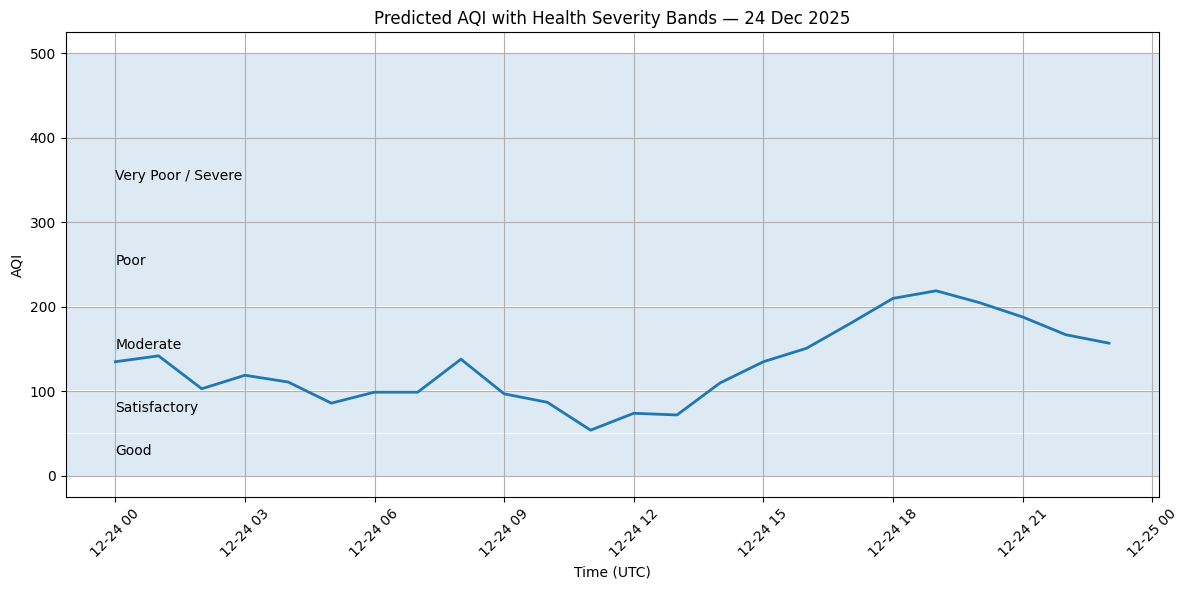

In [100]:
plt.figure(figsize=(12,6))

plt.plot(day_df["datetime"], day_df["AQI_predicted"], label="Predicted AQI", linewidth=2)

# AQI bands (Indian CPCB)
plt.axhspan(0, 50, alpha=0.15)
plt.axhspan(51, 100, alpha=0.15)
plt.axhspan(101, 200, alpha=0.15)
plt.axhspan(201, 300, alpha=0.15)
plt.axhspan(301, 500, alpha=0.15)

plt.text(day_df["datetime"].iloc[0], 25, "Good")
plt.text(day_df["datetime"].iloc[0], 75, "Satisfactory")
plt.text(day_df["datetime"].iloc[0], 150, "Moderate")
plt.text(day_df["datetime"].iloc[0], 250, "Poor")
plt.text(day_df["datetime"].iloc[0], 350, "Very Poor / Severe")

plt.title("Predicted AQI with Health Severity Bands — 24 Dec 2025")
plt.xlabel("Time (UTC)")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


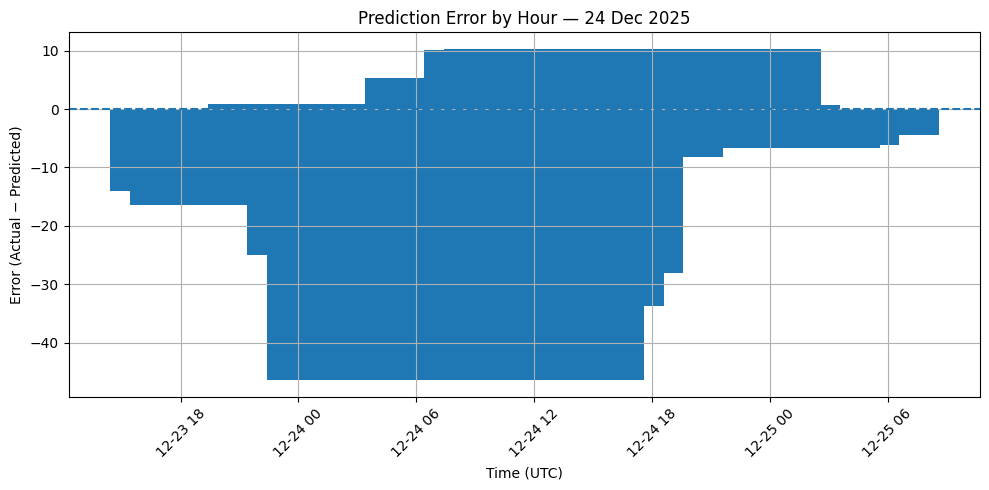

In [101]:
day_df["error"] = day_df["PM2_5"] - day_df["PM2_5_pred"]

plt.figure(figsize=(10,5))
plt.bar(day_df["datetime"], day_df["error"])

plt.axhline(0, linestyle="--")
plt.title("Prediction Error by Hour — 24 Dec 2025")
plt.xlabel("Time (UTC)")
plt.ylabel("Error (Actual − Predicted)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
